# Automatic Differentiation

In [1]:
import functools
import numpy as np
from graphviz import Digraph

## Implement `Variable` (computational graph + backprop)

A `Variable` is a node within a neural network. It has parents and children which together with other nodes forms a graph. It also has a `grad` field to store its gradient calculated using the back propagation algorithm. We implement `Variable` by subclassing `np.ndarray` and intercepting numpy operators to inject our own logic.

In [2]:
def to_np(tensors):
    return tuple(x.view(np.ndarray) if isinstance(x, Variable) else x for x in tensors)

class Variable(np.ndarray):
    next_id = 0
    debug = False
    
    def __array_finalize__(self, obj):
        if self.debug: print(f'__array_finalize__ {self} {obj}')
        if obj is None: return
        self.op = getattr(obj, 'op', None)
        self.parents = getattr(obj, 'parents', None)
        self.children = getattr(obj, 'children', [])
        self.name = getattr(obj, 'name', None)
        self.grad = None
        Variable.next_id, self.id = Variable.next_id + 1, Variable.next_id

    def __array_ufunc__(self, ufunc, method, *args, **kwargs):
        np_args = to_np(args)
        if 'out' in kwargs:
            kwargs['out'] = to_np(kwargs['out'])
        if self.debug: print(f'__array_ufunc__ {ufunc} {np_args} {kwargs}')
        var = super().__array_ufunc__(ufunc, method, *np_args, **kwargs)
        if var is NotImplemented:
            return NotImplemented
        var = var.view(Variable)
        var.op = ufunc
        var.parents = args
        for arg in args:
            if isinstance(arg, Variable):
                arg.children.append(var)
        return var

    def __array_function__(self, func, types, args, kwargs):
        np_args = to_np(args)
        if self.debug: print(f'__array_function__ {func} {np_args}')
        var = func(*np_args, **kwargs)
        if not isinstance(var, np.ndarray):
            var = np.array(var)
        var = var.view(Variable)
        var.op = func
        var.parents = args
        for arg in args:
            if isinstance(arg, Variable):
                arg.children.append(var)
        return var

    def backwards(self, is_root = True):
        """Back propagation

        Unlike the algorithm in the Deep Learning Book chapter 6 where there
        is a global gradient table and gradients are calculated top-down, we
        store gradients within individual nodes and back prop from the loss
        node. This allows us to discover the graph on the fly instead of having
        to know all the nodes in our graph up front.
        """
        if is_root:
            self.grad = np.ones(self.shape)
        else:
            if self.grad is not None:
                return self.grad
            grad = None
            for child in self.children:
                child_grad = child.backwards(False)
                idx = child.parents.index(self)
                grad_child = backprop[child.op](child.parents, idx, child_grad)
                grad = grad_child if self.grad is None else grad + grad_child
            if len(grad.shape) == len(self.shape) + 1:
                # Average gradients in a minibatch
                grad = np.mean(grad, axis=0)
            self.grad = grad
        for parent in self.parents or []:
            if isinstance(parent, Variable):
                parent.backwards(False)
        return self.grad

    def reset_grad(self):
        self.grad = None
        self.children = []
        for parent in self.parents or []:
            if isinstance(parent, Variable):
                parent.reset_grad()

    def graph(self, g=None):
        """Graphviz support"""
        if g is None:
            g = Digraph()
        g.node(str(self.id), label=self.label(), xlabel=self.op.__name__ if self.op else None)
        for parent in self.parents or []:
            if not isinstance(parent, Variable):
                id, Variable.next_id = str(Variable.next_id), Variable.next_id + 1
                g.node(id, label=str(parent))
                g.edge(id, str(self.id))
            else:
                g.edge(str(parent.id), str(self.id))
                parent.graph(g)
        return g

    def __hash__(self):
        return self.id

    def __eq__(self, other):
        return self.id == other.id

    def __repr__(self):
        return f'{self.label()}({str(self)}, grad={self.grad})'

    def label(self):
        return self.name or f'v{self.id}'

def var(x: np.ndarray, name: tuple[str, str]):
    v = x.view(Variable)
    v.name = '.'.join(name)
    return v

In [3]:
def relu(x):
    return np.maximum(x, 0)

def mse(y, y_hat):
    return np.mean(np.square(y - y_hat))

## Implement backprop for all supported operations

Concrete implementation for equation [6.54](https://www.deeplearningbook.org/contents/mlp.html#pf31):

$$ \text{op.bprop}(\text{inputs}, \textsf{X}, \textsf{G}) = \sum_i (\nabla_\textsf{X}\text{op.f}(\text{inputs})_i) ~\textsf{G}_i $$

In [4]:
backprop = {}
def bprop(forward_fn):
    def decorator(backwards_fn):
        @functools.wraps(backwards_fn)
        def wrapper(inputs, idx, G):
            return backwards_fn(to_np(inputs), idx, G)
        backprop[forward_fn] = wrapper
        return wrapper
    return decorator

@bprop(np.add)
def bprop_add(inputs, idx, G):
    return G

@bprop(np.subtract)
def bprop_subtract(inputs, idx, G):
    A, B = inputs
    return G if idx == 0 else -G

@bprop(np.square)
def bprop_square(inputs, idx, G):
    return 2. * inputs[0] * G

@bprop(np.mean)
def bprop_mean(inputs, idx, G):
    return np.ones(inputs[0].shape) / inputs[0].shape[0]

@bprop(np.matmul)
def bprop_matmul(inputs, idx, G):
    A, B = inputs
    match idx:
        case 0: return G @ np.moveaxis(B, -1, -2)
        case 1: return A.T @ G

@bprop(np.maximum)
def bprop_maximum(inputs, idx, G):
    A, B = inputs
    mask = A > B if idx == 0 else B > A
    return mask.astype(np.float64) * G

@bprop(np.squeeze)
def bprop_squeeze(inputs, idx, G):
    return np.expand_dims(G, -1)

@bprop(np.expand_dims)
def bprop_expand_dims(inputs, idx, G):
    return np.squeeze(G, -1)

## Implement basic neural network primitives

In [5]:
class Module:
    def parameters(self):
        out = []
        for attr in self.__dict__.values():
            if isinstance(attr, Variable):
                out.append(attr)
            elif isinstance(attr, Module):
                out.extend(attr.parameters())
        return set(out)

class Linear(Module):
    def __init__(self, in_dim: int, out_dim: int, name: str = 'fc'):
        self.W = var(np.random.randn(out_dim, in_dim), name=(name, 'W'))
        self.b = var(np.random.randn(out_dim), name=(name, 'b'))

    def __call__(self, x):
        return np.squeeze(self.W @ np.expand_dims(x, axis=-1), axis=-1) + self.b

class SGD:
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr

    def step(self):
        for var in self.params:
            var -= var.grad * self.lr

def train(model, X, y_true, optim, max_epochs=100, log_epochs=1, epilson=0.000001):
    for i in range(max_epochs):
        y_pred = model(x)
        loss = mse(y_pred, y_true)
        if loss.item() <= epilson:
            break
        if i % log_epochs == 0:
            print(f'epoch {i} | loss = {loss.item():.5f}')
        loss.backwards()
        optim.step()
        loss.reset_grad()
    return i, loss

In [6]:
class MLP(Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        self.fc1 = Linear(in_dim, hidden_dim, name='fc1')
        self.fc2 = Linear(hidden_dim, out_dim, name='fc2')

    def __call__(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x

## Demo 1: Learn XOR

In [7]:
np.random.seed(0)

x = var(np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]]), name='x')
y_true = var(np.array([[0.], [1.], [1.], [0.]]), name='y')

model = MLP(2, 2, 1)
optim = SGD(model.parameters(), lr=0.01)
epochs, loss = train(model, x, y_true, optim, max_epochs=100000, log_epochs=5000)
print(f'Total epochs = {epochs} | train loss = {loss}')
print(np.array_repr(model(x), suppress_small=True))

epoch 0 | loss = 5.12959
epoch 5000 | loss = 0.05116
epoch 10000 | loss = 0.00488
epoch 15000 | loss = 0.00020
epoch 20000 | loss = 0.00001
Total epochs = 22815 | train loss = 9.998821010551953e-07
array([[0.00172329],
       [0.99934252],
       [0.99928032],
       [0.00028212]])


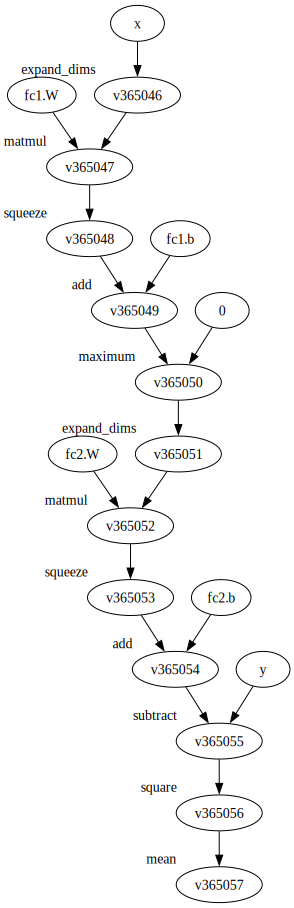

In [8]:
loss.graph()